In [1]:
import numpy as np
import pandas as pd

from cvxopt import solvers
solvers.options['show_progress'] = False

import sys
sys.path.append("../graph_signal_processing")

from graph_generator import line_graph, grid_graph, rbf_random_graph, er_random_graph
from graph_signal_generator import heat_signal_generator
from learn_heat import learn_heat
from metrics import F1_score

import matplotlib.pyplot as plt

# Generating heat diffusion graph signals

Le modèle du signal est:
$$ x = \mathcal{D}h + \epsilon$$
où $h$ est une variable latente, $\mathcal{D}$ est la matrice de représentation. Dans la suite, nous ferons l'hyptohèse que des informations sur la structure du graphe sont contenues dans cette matrice. En particulier, on peut supposer que D est un dictionnaire de motifs spectraux du graph. 

Dans la suite, nous allons nous intéresser aux processes de diffusion sur graphs. La matrice du Laplacien sera utilisée pour modéliser cette diffusion (cf equation de la chaleur). 
$$ D = [exp(-\tau_1 L), exp(-\tau_2), ...]$$

# Learning graphs from heat diffusion signals

In [2]:
true_tau = [1.]
n_samples = 1000 # number of signals simulated for each graph
n_steps = 100 # number of maximum steps in learn_heat
n_trials = 10 # number of trials for each graph and each set of parameters

# hyperparameters for the grid search
alpha_ = np.logspace(-6, 1, 8)
beta_ = np.logspace(-4, 1, 6)
threshold_ = np.logspace(-3, -1, 3)

## Line graph

In [3]:
L = line_graph(16)

In [4]:
list_alpha = []
list_beta = []
list_threshold = []
list_F1 = []

best = 0.
for alpha in alpha_:
    for beta in beta_:
        stats = [0] * len(threshold_)
        for _ in range(n_trials):
            samples, _ = heat_signal_generator(L, true_tau, n_samples)
            pred_L, _, _ = learn_heat(samples, n_step=n_steps, beta=beta, alpha=alpha, s=len(true_tau), log_step=500, true_tau=true_tau)
            for i, threshold in enumerate(threshold_):
                stats[i] += F1_score(L, pred_L, threshold=threshold)
        for i, threshold in enumerate(threshold_):
            list_alpha.append(alpha)
            list_beta.append(beta)
            list_threshold.append(threshold)
            F1 = stats[i] / n_trials
            list_F1.append(F1)
            if F1 > best:
                best = F1
                print("alpha : {0}; beta : {1}; threshold : {2} --> F1 = {3}".format(alpha, beta, threshold, F1))
results_list = pd.DataFrame({"alpha" : list_alpha, "beta" : list_beta, "threshold" : list_threshold, "F1" : list_F1})
        

alpha : 1e-06; beta : 0.0001; threshold : 0.001 --> F1 = 0.2960669698997694
alpha : 1e-06; beta : 0.0001; threshold : 0.01 --> F1 = 0.3563721689363116
alpha : 1e-06; beta : 0.0001; threshold : 0.1 --> F1 = 0.9838501112347053
alpha : 1e-06; beta : 0.001; threshold : 0.1 --> F1 = 0.9838709677419356
alpha : 1e-06; beta : 0.01; threshold : 0.1 --> F1 = 0.9967741935483871
alpha : 0.0001; beta : 0.01; threshold : 0.1 --> F1 = 1.0


../graph_signal_processing/learn_heat.py:211: RuntimeWarning: divide by zero encountered in double_scalars
  diffusion_factors = np.maximum(- 1 / e_ * (grad_tau - e_ * diffusion_factors),
../graph_signal_processing/learn_heat.py:211: RuntimeWarning: invalid value encountered in multiply
  diffusion_factors = np.maximum(- 1 / e_ * (grad_tau - e_ * diffusion_factors),


ValueError: domain error

In [7]:
results_list = pd.DataFrame({"alpha" : list_alpha, "beta" : list_beta, "threshold" : list_threshold, "F1" : list_F1})

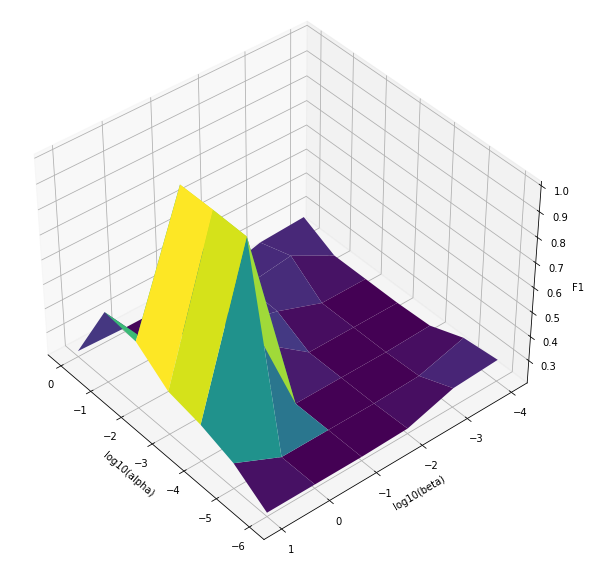

In [21]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
X = np.log(np.repeat(alpha_[np.newaxis, :-1], len(beta_), axis=0)) / np.log(10)
Y = np.log(np.repeat(beta_[np.newaxis, ], len(alpha_)-1, axis=0).T) / np.log(10)
Z = results_list[results_list["threshold"] == 0.001]["F1"].values.reshape((len(beta_), len(alpha_)-1), order="C")
#ax.contour3D(X, Y, Z, 75, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('log10(alpha)')
ax.set_ylabel('log10(beta)')
ax.set_zlabel('F1')
ax.view_init(40, 140)
plt.show()

## Grid graph

In [6]:
L = grid_graph(16)

In [7]:
alpha_ = np.logspace(-9, 0, 10)
beta_ = np.logspace(-9, 0, 10)

list_alpha = []
list_beta = []
list_threshold = []
list_F1 = []

best = 0.

for alpha in alpha_:
    for beta in beta_:
        stats = [0] * len(threshold_)
        for _ in range(n_trials):
            samples, _ = heat_signal_generator(L, true_tau, n_samples)
            pred_L, _, _ = learn_heat(samples, n_step=n_steps, beta=beta, alpha=alpha, s=len(true_tau), log_step=500, true_tau=true_tau)
            for i, threshold in enumerate(threshold_):
                stats[i] += F1_score(L, pred_L, threshold=threshold)
        for i, threshold in enumerate(threshold_):
            list_alpha.append(alpha)
            list_beta.append(beta)
            list_threshold.append(threshold)
            F1 = stats[i] / n_trials
            list_F1.append(F1)
            if F1 > best:
                best = F1
            print("alpha : {0}; beta : {1}; threshold : {2} --> F1 = {3}".format(alpha, beta, threshold, F1))
results_grid = pd.DataFrame({"alpha" : list_alpha, "beta" : list_beta, "threshold" : list_threshold, "F1" : list_F1})
results_grid.to_csv("learnHeat_grid_16_nodes_100_steps_5_trials.csv")     

alpha : 1e-09; beta : 1e-09; threshold : 0.001 --> F1 = 0.4392370078416876
alpha : 1e-09; beta : 1e-09; threshold : 0.01 --> F1 = 0.5045150987581246
alpha : 1e-09; beta : 1e-09; threshold : 0.1 --> F1 = 0.9624855072463768
alpha : 1e-09; beta : 1e-08; threshold : 0.001 --> F1 = 0.430406289178858
alpha : 1e-09; beta : 1e-08; threshold : 0.01 --> F1 = 0.5032541483152171
alpha : 1e-09; beta : 1e-08; threshold : 0.1 --> F1 = 0.9939591836734694
alpha : 1e-09; beta : 1e-07; threshold : 0.001 --> F1 = 0.4382095450488729
alpha : 1e-09; beta : 1e-07; threshold : 0.01 --> F1 = 0.5187339874965609
alpha : 1e-09; beta : 1e-07; threshold : 0.1 --> F1 = 0.9670918367346939
alpha : 1e-09; beta : 1e-06; threshold : 0.001 --> F1 = 0.4413268188846213
alpha : 1e-09; beta : 1e-06; threshold : 0.01 --> F1 = 0.512057077612774
alpha : 1e-09; beta : 1e-06; threshold : 0.1 --> F1 = 0.9979591836734694
alpha : 1e-09; beta : 1e-05; threshold : 0.001 --> F1 = 0.44147672451246667
alpha : 1e-09; beta : 1e-05; threshold

alpha : 1e-06; beta : 0.1; threshold : 0.001 --> F1 = 0.3333333333333334
alpha : 1e-06; beta : 0.1; threshold : 0.01 --> F1 = 0.3333333333333334
alpha : 1e-06; beta : 0.1; threshold : 0.1 --> F1 = 0.44772985233218526
alpha : 1e-06; beta : 1.0; threshold : 0.001 --> F1 = 0.3333333333333334
alpha : 1e-06; beta : 1.0; threshold : 0.01 --> F1 = 0.3333333333333334
alpha : 1e-06; beta : 1.0; threshold : 0.1 --> F1 = 0.0
alpha : 1e-05; beta : 1e-09; threshold : 0.001 --> F1 = 0.4282684521942569
alpha : 1e-05; beta : 1e-09; threshold : 0.01 --> F1 = 0.5023584104500362
alpha : 1e-05; beta : 1e-09; threshold : 0.1 --> F1 = 1.0
alpha : 1e-05; beta : 1e-08; threshold : 0.001 --> F1 = 0.43054985497908893
alpha : 1e-05; beta : 1e-08; threshold : 0.01 --> F1 = 0.5040776406852074
alpha : 1e-05; beta : 1e-08; threshold : 0.1 --> F1 = 0.9895390070921986
alpha : 1e-05; beta : 1e-07; threshold : 0.001 --> F1 = 0.43604569433049917
alpha : 1e-05; beta : 1e-07; threshold : 0.01 --> F1 = 0.5091866619468604
al

alpha : 0.01; beta : 0.001; threshold : 0.001 --> F1 = 0.5276943087489668
alpha : 0.01; beta : 0.001; threshold : 0.01 --> F1 = 0.631269263949504
alpha : 0.01; beta : 0.001; threshold : 0.1 --> F1 = 1.0
alpha : 0.01; beta : 0.01; threshold : 0.001 --> F1 = 0.38289971985406956
alpha : 0.01; beta : 0.01; threshold : 0.01 --> F1 = 0.44891586141589457
alpha : 0.01; beta : 0.01; threshold : 0.1 --> F1 = 1.0
alpha : 0.01; beta : 0.1; threshold : 0.001 --> F1 = 0.3333333333333334
alpha : 0.01; beta : 0.1; threshold : 0.01 --> F1 = 0.3333333333333334
alpha : 0.01; beta : 0.1; threshold : 0.1 --> F1 = 0.8752732656156386
alpha : 0.01; beta : 1.0; threshold : 0.001 --> F1 = 0.3333333333333334
alpha : 0.01; beta : 1.0; threshold : 0.01 --> F1 = 0.3333333333333334
alpha : 0.01; beta : 1.0; threshold : 0.1 --> F1 = 0.0
alpha : 0.1; beta : 1e-09; threshold : 0.001 --> F1 = 0.9291423952756054
alpha : 0.1; beta : 1e-09; threshold : 0.01 --> F1 = 0.9198664723086555
alpha : 0.1; beta : 1e-09; threshold :

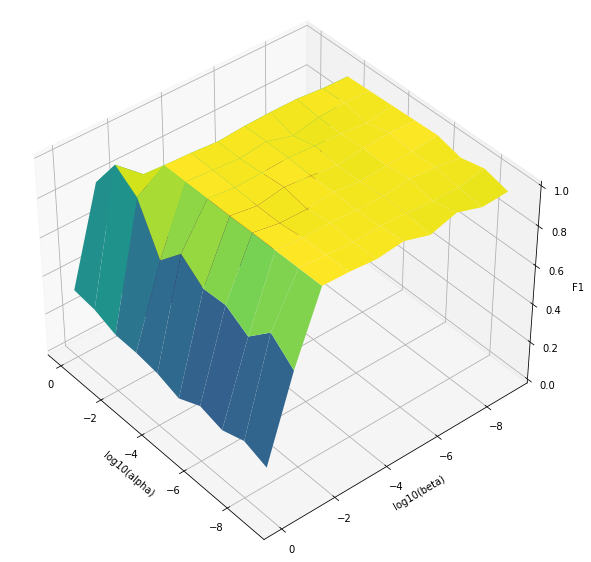

In [8]:
results_grid = pd.DataFrame({"alpha" : list_alpha, "beta" : list_beta, "threshold" : list_threshold, "F1" : list_F1})
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
X = np.log(np.repeat(alpha_[np.newaxis,], len(beta_), axis=0)) / np.log(10)
Y = np.log(np.repeat(beta_[np.newaxis, ], len(alpha_), axis=0).T) / np.log(10)
Z = results_grid[results_grid["threshold"] == 0.1]["F1"].values.reshape((len(beta_), len(alpha_)), order="C")
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('log10(alpha)')
ax.set_ylabel('log10(beta)')
ax.set_zlabel('F1')
ax.view_init(40, 140)
plt.show()

## RBF graph

In [9]:
list_alpha = []
list_beta = []
list_threshold = []
list_F1 = []

best = 0.

for alpha in alpha_:
    for beta in beta_:
        stats = [0] * len(threshold_)
        for _ in range(n_trials):
            L = rbf_random_graph(16)
            samples, _ = heat_signal_generator(L, true_tau, n_samples)
            pred_L, _, _ = learn_heat(samples, n_step=n_steps, beta=beta, alpha=alpha, s=len(true_tau), log_step=500, true_tau=true_tau)
            for i, threshold in enumerate(threshold_):
                stats[i] += F1_score(L, pred_L, threshold=threshold)
        for i, threshold in enumerate(threshold_):
            list_alpha.append(alpha)
            list_beta.append(beta)
            list_threshold.append(threshold)
            F1 = stats[i] / n_trials
            list_F1.append(F1)
            if F1 > best:
                best = F1
                print("alpha : {0}; beta : {1}; threshold : {2} --> F1 = {3}".format(alpha, beta, threshold, F1))
results_rbf = pd.DataFrame({"alpha" : list_alpha, "beta" : list_beta, "threshold" : list_threshold, "F1" : list_F1})
results_rbf.to_csv("learnHeat_rbf_16_nodes_100_steps_5_trials.csv")     

alpha : 1e-09; beta : 1e-09; threshold : 0.001 --> F1 = 0.7188962205384083
alpha : 1e-09; beta : 1e-09; threshold : 0.01 --> F1 = 0.7867808765224515
alpha : 1e-09; beta : 1e-09; threshold : 0.1 --> F1 = 0.8020248889124417
alpha : 1e-09; beta : 1e-08; threshold : 0.01 --> F1 = 0.812641608754028
alpha : 1e-09; beta : 1e-07; threshold : 0.01 --> F1 = 0.8281170625637413
alpha : 1e-08; beta : 1e-05; threshold : 0.01 --> F1 = 0.8289545820435823
alpha : 1e-07; beta : 0.001; threshold : 0.01 --> F1 = 0.8375326835747682
alpha : 1e-06; beta : 1e-05; threshold : 0.01 --> F1 = 0.8427053458684416
alpha : 1e-05; beta : 1e-09; threshold : 0.01 --> F1 = 0.8452289693842081
alpha : 0.01; beta : 1e-09; threshold : 0.01 --> F1 = 0.8967380945709728
alpha : 0.01; beta : 1e-07; threshold : 0.01 --> F1 = 0.9066547537285332


../graph_signal_processing/learn_heat.py:211: RuntimeWarning: divide by zero encountered in double_scalars
  diffusion_factors = np.maximum(- 1 / e_ * (grad_tau - e_ * diffusion_factors),
../graph_signal_processing/learn_heat.py:211: RuntimeWarning: invalid value encountered in multiply
  diffusion_factors = np.maximum(- 1 / e_ * (grad_tau - e_ * diffusion_factors),


ValueError: domain error

In [19]:
list_alpha.append(1)
list_beta.append(1)
list_threshold.append(0.01)
list_F1.append(0)

In [22]:
results_rbf

,alpha,beta,threshold,F1
0,1.000000e-09,1.000000e-09,0.001,0.718896
1,1.000000e-09,1.000000e-09,0.010,0.786781
2,1.000000e-09,1.000000e-09,0.100,0.802025
3,1.000000e-09,1.000000e-08,0.001,0.746963
4,1.000000e-09,1.000000e-08,0.010,0.812642
...,...,...,...,...
295,1.000000e+00,1.000000e-01,0.010,0.529149
296,1.000000e+00,1.000000e-01,0.100,0.527789
297,1.000000e+00,1.000000e+00,0.000,0.000000
298,1.000000e+00,1.000000e+00,0.000,0.000000


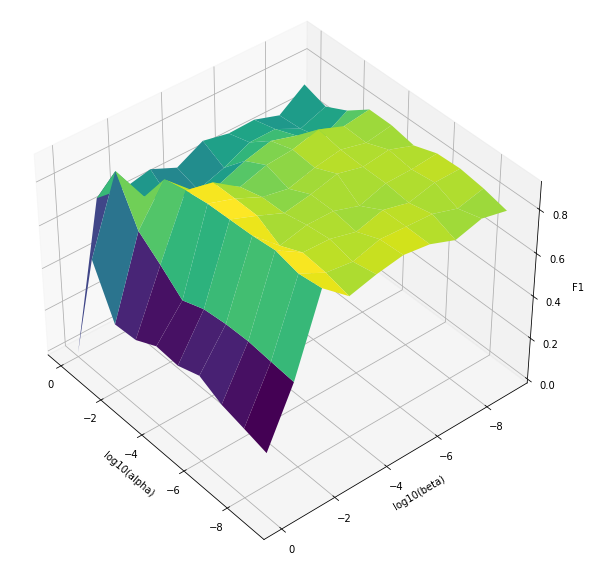

In [24]:
results_rbf = pd.DataFrame({"alpha" : list_alpha, "beta" : list_beta, "threshold" : list_threshold, "F1" : list_F1})
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
X = np.log(np.repeat(alpha_[np.newaxis, ], len(beta_), axis=0)) / np.log(10)
Y = np.log(np.repeat(beta_[np.newaxis, ], len(alpha_), axis=0).T) / np.log(10)
Z = results_rbf[results_rbf["threshold"] == 0.01]["F1"].values.reshape((len(beta_), len(alpha_)), order="C")
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('log10(alpha)')
ax.set_ylabel('log10(beta)')
ax.set_zlabel('F1')
ax.view_init(40, 140)
plt.show()

# Some visualizations

## Line

In [25]:
L = line_graph(16)
samples, H = heat_signal_generator(L, true_tau, n_samples)
pred_L, pred_H, _ = learn_heat(samples, n_step=n_steps, beta=1e-2, alpha=1e-4, s=len(true_tau), log_step=500, true_tau=true_tau)

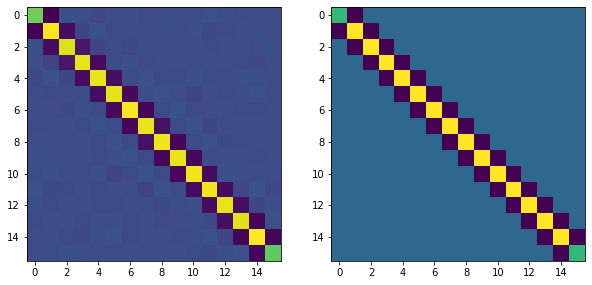

In [26]:
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(pred_L)
plt.subplot(1, 2, 2)
plt.imshow(L)

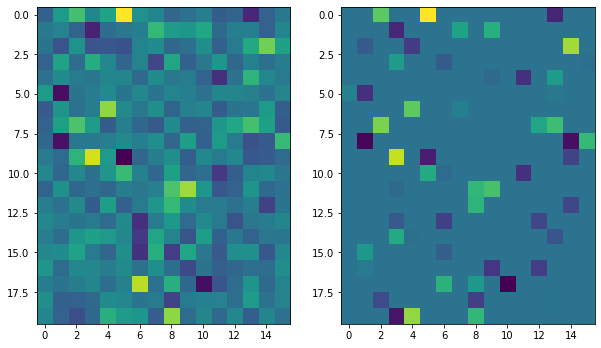

In [27]:
plt.figure(figsize=(10, 100))
plt.subplot(1, 2, 1)
plt.imshow(pred_H[:20, :20])
plt.subplot(1, 2, 2)
plt.imshow(H[:20, :20])

## Grid

In [28]:
L = grid_graph(16)
samples, H = heat_signal_generator(L, true_tau, n_samples)
pred_L, pred_H, _ = learn_heat(samples, n_step=n_steps, beta=1e-2, alpha=1e-2, s=len(true_tau), log_step=500, true_tau=true_tau)

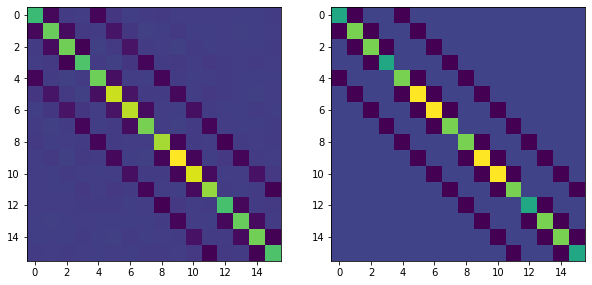

In [29]:
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(pred_L)
plt.subplot(1, 2, 2)
plt.imshow(L)

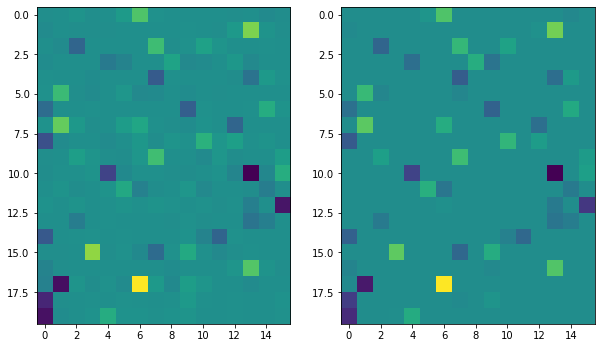

In [30]:
plt.figure(figsize=(10, 100))
plt.subplot(1, 2, 1)
plt.imshow(pred_H[:20, :20])
plt.subplot(1, 2, 2)
plt.imshow(H[:20, :20])

## RBF

In [31]:
L = rbf_random_graph(16)
samples, H = heat_signal_generator(L, true_tau, n_samples)
pred_L, pred_H, _ = learn_heat(samples, n_step=n_steps, beta=1e-7, alpha=1e-2, s=len(true_tau), log_step=500, true_tau=true_tau)

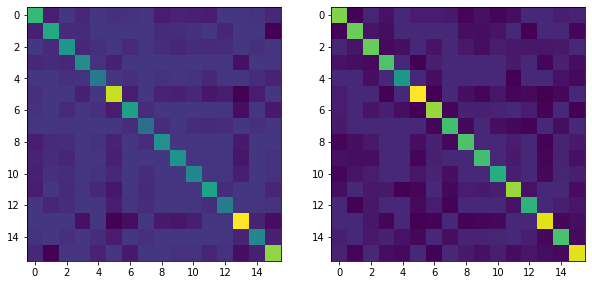

In [32]:
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(pred_L)
plt.subplot(1, 2, 2)
plt.imshow(L)

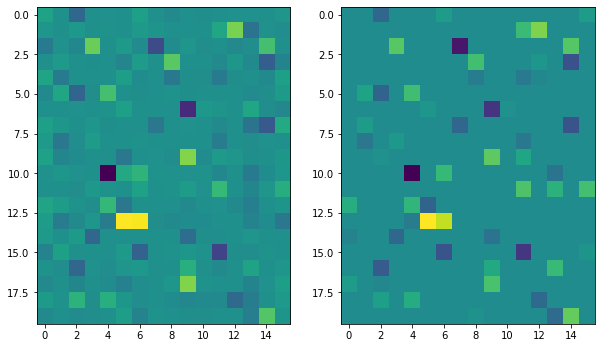

In [33]:
plt.figure(figsize=(10, 200))
plt.subplot(1, 2, 1)
plt.imshow(pred_H[:20, :20])
plt.subplot(1, 2, 2)
plt.imshow(H[:20, :20])